# Dataset

We used a subset of WaterDrop dataset from Deepmind. The videos only covers the specific case of a water droplet in vacuum, but that is fine with us, as that is exactly what we wanted to model!

## Converting TFRecord to torch tensors

Unfortunately, the dataset is not available in a format that is easy to use with PyTorch. We need to convert it to a format that is more suitable for PyTorch (e.g. `torch.Tensor`).

We achieve this by iterating over the TFRecord file, extracting the features for each frame and adding this information to its corresponding trajctory. We then save the trajectories as a pickle file.

In [1186]:
from read_dataset import prepare_data_from_tfds
import torch

generate_trajectories = False

if generate_trajectories:
    # initialize dataset
    # this is of type tf.data.Dataset
    ds = prepare_data_from_tfds(data_path='dataset/WaterDrop/train.tfrecord', is_rollout=False, batch_size=1)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # kepp track of the number of batches we iterate over in the dataset
    batch_count = 0
    # there are many trajectories in the dataset, we want to save each trajectory in a separate folder
    number_of_trajectories = 0
    number_of_frames_in_trajectory = {}

    # this are the features we want to extract from the dataset
    positions = {}
    particle_type = {}
    labels = {}

    print('started loading data...')
    for features, current_labels in ds:
        
        # extract feature
        number_of_particles = features['n_particles_per_example'][0]
        current_positions = torch.tensor(features['position']).to(device)
        current_labels = torch.tensor(current_labels).to(device)
        
        # if this is the first time we see this number of particles
        # i.e. this is a new trajectory
        if number_of_particles not in positions.keys():
            number_of_trajectories += 1
            number_of_frames_in_trajectory[number_of_particles] = 1
            positions[number_of_particles] = current_positions
            labels[number_of_particles] = current_labels
            particle_type[number_of_particles] = torch.tensor(features['particle_type']).to(device)
        
        else:
            # and if else is required here beacuse we need to stack the first two frames, and only than we can cat
            if number_of_frames_in_trajectory[number_of_particles] == 1:
                positions[number_of_particles] = torch.stack((positions[number_of_particles], current_positions), dim=0)
                labels[number_of_particles] = torch.stack((labels[number_of_particles], current_labels), dim=0)
                particle_type[number_of_particles] = torch.stack((particle_type[number_of_particles], torch.tensor(features['particle_type']).to(device)), dim=0)
            
            else:
                positions[number_of_particles] = torch.cat((positions[number_of_particles], current_positions.unsqueeze(0)), dim=0)
                labels[number_of_particles] = torch.cat((labels[number_of_particles], current_labels.unsqueeze(0)), dim=0)
                particle_type[number_of_particles] = torch.cat((particle_type[number_of_particles], torch.tensor(features['particle_type']).to(device).unsqueeze(0)), dim=0)
                
            number_of_frames_in_trajectory[number_of_particles] += 1
        
        print(f'batch {batch_count} done; number of trajectories: {number_of_trajectories}')
        batch_count += 1
        
        # the main way to end the loop
        # change this if you want a different number of trajectories
        # note: trajectories are randomly mixes and do not appear in the
        if number_of_trajectories == 22:
            break
        
    print('all batches done')
    print('converting to tensors...')

    import shutil
    import os

    trajectory_dir_count = 0
    for trajectory_dir_count, n_particles in enumerate(positions.keys()):
        if os.path.exists(f'data/trajectories/{trajectory_dir_count}'):
            shutil.rmtree(f'data/trajectories/{trajectory_dir_count}')
            print(f'data/trajectories/{trajectory_dir_count} deleted')
            
        os.makedirs(f'data/trajectories/{trajectory_dir_count}')
        print(f'data/trajectories/{trajectory_dir_count} created')
        
        with open(f'data/trajectories/{trajectory_dir_count}/positions.pt', 'wb') as f:
            torch.save(positions[n_particles], f)
            print(f'data/trajectories/{trajectory_dir_count}/positions.pt saved')
            
        with open(f'data/trajectories/{trajectory_dir_count}/labels.pt', 'wb') as f:
            torch.save(labels[n_particles], f)
            print(f'data/trajectories/{trajectory_dir_count}/labels.pt saved')
            
        with open(f'data/trajectories/{trajectory_dir_count}/particle_type.pt', 'wb') as f:
            torch.save(particle_type[n_particles], f)
            print(f'data/trajectories/{trajectory_dir_count}/particle_type.pt saved')

## Sorting the frames
Below is the function that calculates the permutation that sorts the data by the frame number.

In [1]:
import numpy as np

# sort frames
def get_sorted_data(data):
    '''
    data: numpy array: (num_of_frames, number_of_particles, dimension)
    return: numpy (num_of_frames, number_of_particles, dimension), with sorted frames
    '''
    
    # class for groups representation: arrays of frames
    class ObjectGroup:
        def __init__(self, elems):
            self.elems = elems
        
        def add_to_begining(self, elem):
            self.elems.insert(0, elem)
        
        def add_to_end(self, elem):
            self.elems.append(elem)

        def reverse(self):
            self.elems.reverse()

    # merge
    def merge_groups(g1, g2):
        lst = g1.elems
        lst.extend(g2.elems)
        return ObjectGroup(lst)

    # min distance between groups: potentially can be merged front and back 
    def get_difference(group1, group2):
        dist1 = d_matrix[group1.elems[0], group2.elems[0]]
        dist2 = d_matrix[group1.elems[0], group2.elems[-1]]
        dist3 = d_matrix[group1.elems[-1], group2.elems[0]]
        dist4 = d_matrix[group1.elems[-1], group2.elems[-1]]
        return min(dist1, dist2, dist3, dist4)

    # get index: for flipping
    def get_ind(group1, group2):
        d = get_difference(group1, group2)
        if d == d_matrix[group1.elems[0], group2.elems[0]]:
            return 1
        if d == d_matrix[group1.elems[0], group2.elems[-1]]:
            return 2
        if d == d_matrix[group1.elems[-1], group2.elems[0]]:
            return 3
        if d == d_matrix[group1.elems[-1], group2.elems[-1]]:
            return 4
        return 4
    
    # define distance
    def get_distance(points_1, points_2):
        return np.sum(np.abs(points_1-points_2)**2)**(1./2)

    # calculate distances
    def calculate_distance_matrix(points):
        d_matrix = np.zeros((len(points), len(points)))
        for i in range(len(points)):
            for j in range(len(points)):
                d_matrix[i,j] = get_distance(points[i], points[j])
                d_matrix[j,i] = d_matrix[i,j]
        #print(np.max(d_matrix))
        return d_matrix

    # objects:
    obj_list = []
    p = []
    for i in range(data.shape[0]):
        oo = ObjectGroup([i])
        obj_list.append(oo)
        p.append(data[i])

    d_matrix = calculate_distance_matrix(p)

    # at each iteration we merge sequences until one remains
    for i in range(data.shape[0]-1):
        ind_1 = -1
        ind_2 = -1
        min_dist = np.inf
        for j in range(len(obj_list)):
            for k in range(j+1, len(obj_list)):
                dist = get_difference(obj_list[j], obj_list[k])
                if dist < min_dist:
                    min_dist = dist
                    ind_1 = j
                    ind_2 = k
        which_d = get_ind(obj_list[ind_1], obj_list[ind_2])
        
        # which lists flip
        if which_d == 1 or which_d == 2:
            obj_list[ind_1].reverse()
        if which_d == 2 or which_d == 4:
            obj_list[ind_2].reverse()
        obj_1 = obj_list[ind_1]
        obj_2 = obj_list[ind_2]
        merged = merge_groups(obj_1, obj_2)

        # update obj_list
        obj_list.remove(obj_1)
        obj_list.remove(obj_2)
        obj_list.append(merged)
    
    #print(obj_list[0].elems)
    l = obj_list[0].elems
    #sorted_d = data[obj_list[0].elems]
    if get_distance(data[l[0]], data[l[1]]) > get_distance(data[l[-1]], data[l[-2]]):
        l = l[::-1]
    
    return data[l], l

Now that we have the permutations, we can sort the data. For convenience, we have included the permutation indexes for the first 20 trajectories. This way, you don't have to wait for the sorting to finish. You can find them in `permutations.py`. Each permutation is a list of integers, where the index of the integer is the frame number and the value is the index of the frame in the original trajectory.

In [2]:
import permutations
import os
import shutil
import torch

shutil.rmtree('./data/train')
shutil.rmtree('./data/valid')
shutil.rmtree('./data/test')

os.makedirs('./data/train', exist_ok=True)
os.makedirs('./data/valid', exist_ok=True)
os.makedirs('./data/test', exist_ok=True)

# for each of the train, valid, test specify what trajectories to use
n_train = 12
n_valid = 3
n_test = 3
train_indexes = [i for i in range(n_train)]
valid_indexes = [i for i in range(n_train, n_train+n_valid)]
test_indexes = [i for i in range(n_train+n_valid, n_train+n_valid+n_test)]

indexes = permutations.indexes

print(len(indexes))
for i in range(len(indexes)):
    for j in range(995,1000):
        try:
            indexes[i].remove(j)
        except:
            print(i, j)

for train_index in train_indexes:
    positions = torch.load('./data/trajectories/{}/positions.pt'.format(train_index))
    labels = torch.load('./data/trajectories/{}/labels.pt'.format(train_index))
    particle_type = torch.load('./data/trajectories/{}/particle_type.pt'.format(train_index))
    positions = positions[indexes[train_index]]
    labels = labels[indexes[train_index]]
    particle_type = particle_type[indexes[train_index]]
    os.makedirs('./data/train/{}'.format(train_index), exist_ok=True)
    with open('./data/train/{}/positions.pt'.format(train_index), 'wb') as f:
        torch.save(positions, f)
    with open('./data/train/{}/labels.pt'.format(train_index), 'wb') as f:
        torch.save(labels, f)
    with open('./data/train/{}/particle_type.pt'.format(train_index), 'wb') as f:
        torch.save(particle_type, f)

for valid_index in valid_indexes:
    positions = torch.load('./data/trajectories/{}/positions.pt'.format(valid_index))
    labels = torch.load('./data/trajectories/{}/labels.pt'.format(valid_index))
    particle_type = torch.load('./data/trajectories/{}/particle_type.pt'.format(valid_index))
    positions = positions[indexes[valid_index]]
    labels = labels[indexes[valid_index]]
    particle_type = particle_type[indexes[valid_index]]
    os.makedirs('./data/valid/{}'.format(valid_index), exist_ok=True)
    with open('./data/valid/{}/positions.pt'.format(valid_index), 'wb') as f:
        torch.save(positions, f)
    with open('./data/valid/{}/labels.pt'.format(valid_index), 'wb') as f:
        torch.save(labels, f)
    with open('./data/valid/{}/particle_type.pt'.format(valid_index), 'wb') as f:
        torch.save(particle_type, f)

for test_index in test_indexes:
    positions = torch.load('./data/trajectories/{}/positions.pt'.format(test_index))
    labels = torch.load('./data/trajectories/{}/labels.pt'.format(test_index))
    particle_type = torch.load('./data/trajectories/{}/particle_type.pt'.format(test_index))
    positions = positions[indexes[test_index]]
    labels = labels[indexes[test_index]]
    particle_type = particle_type[indexes[test_index]]
    os.makedirs('./data/test/{}'.format(test_index), exist_ok=True)
    with open('./data/test/{}/positions.pt'.format(test_index), 'wb') as f:
        torch.save(positions, f)
    with open('./data/test/{}/labels.pt'.format(test_index), 'wb') as f:
        torch.save(labels, f)
    with open('./data/test/{}/particle_type.pt'.format(test_index), 'wb') as f:
        torch.save(particle_type, f)

18


## Extracting the positions

The last step of our data preparation step is to extract the positions. In the dataset, for each frame and for every particle, there is a window of size 6, which contains the information about the previous positions. We want to extract it in such a way, that each position tensor will have a shape of size `(<number of frames = 1000>, <number of particles>, <dimension> = 2)`. This way we have the complete freedom to choose the window size.

In [3]:
import os
import torch

data_types = ('train', 'valid', 'test')
for data_type in data_types:
    trajectory_path = os.path.join('data', data_type)
    for trajectory_i in os.listdir(trajectory_path):
        position_seq = torch.load(os.path.join(trajectory_path, trajectory_i, 'positions.pt'))
        if len(position_seq.shape) == 3:
            continue
        # from the first frame (dimension 0)
        # for all of the particles (dimension 1)
        # get the first 5 positions (dimension 2)
        # and the x and y coordinates (dimension 3)
        # and extract them in a tensor of shape (5, num_particles, 2)
        first_5_positions = position_seq[0, :, :5, :]
        first_5_positions = first_5_positions.permute(1, 0, 2)
        # for all the other frames
        # extract only the last position
        # and join them to the first 5 positions
        # to get the final shape of (num_frames = 1000, num_particles, 2)
        last_positions = position_seq[:, :, -1, :]
        final_positions = torch.cat((first_5_positions, last_positions), dim=0)
        # save the final positions
        with open(os.path.join(trajectory_path, trajectory_i, 'positions.pt'), 'wb') as f:
            print(f'fixed {trajectory_i}')
            torch.save(final_positions, f)

fixed 0
fixed 1
fixed 10
fixed 11
fixed 2
fixed 3
fixed 4
fixed 5
fixed 6
fixed 7
fixed 8
fixed 9
fixed 12
fixed 13
fixed 14
fixed 15
fixed 16
fixed 17


In [4]:
import torch
import torch_geometric as pyg

def generate_noise(position_seq, noise_std=3e-4):
    """Generate noise for a trajectory"""
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]
    time_steps = velocity_seq.size(1)
    velocity_noise = torch.randn_like(velocity_seq) * (noise_std / time_steps ** 0.5)

    # restrict possible values: |velocity_noise[i,j,k]| <= (noise_std / time_steps ** 0.5)
    velocity_noise = torch.minimum(velocity_noise, torch.ones(velocity_noise.shape) * (noise_std / time_steps ** 0.5))
    velocity_noise = torch.maximum(velocity_noise, -torch.ones(velocity_noise.shape) * (noise_std / time_steps ** 0.5))
    
    velocity_noise = velocity_noise.cumsum(dim=1)
    position_noise = velocity_noise.cumsum(dim=1)
    position_noise = torch.cat((torch.zeros_like(position_noise)[:, 0:1], position_noise), dim=1)
    return position_noise


def preprocess(particle_type, position_seq, target_position, metadata, noise_std=3e-4):
    """Preprocess a trajectory and construct the graph"""
    # apply noise to the trajectory
    position_noise = generate_noise(position_seq, noise_std)
    position_seq = position_seq + position_noise

    # calculate the velocities of particles
    recent_position = position_seq[:, -1]
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]

    # construct the graph based on the distances between particles
    n_particle = recent_position.size(0)
    edge_index = pyg.nn.radius_graph(recent_position, metadata["default_connectivity_radius"], loop=True, max_num_neighbors=n_particle)
    
    # node-level features: velocity, distance to the boundary
    normal_velocity_seq = (velocity_seq - torch.tensor(metadata["vel_mean"])) / torch.sqrt(torch.tensor(metadata["vel_std"]) ** 2 + noise_std ** 2)
    boundary = torch.tensor(metadata["bounds"])
    distance_to_lower_boundary = recent_position - boundary[:, 0]
    distance_to_upper_boundary = boundary[:, 1] - recent_position
    distance_to_boundary = torch.cat((distance_to_lower_boundary, distance_to_upper_boundary), dim=-1)
    distance_to_boundary = torch.clip(distance_to_boundary / metadata["default_connectivity_radius"], -1.0, 1.0)

    # edge-level features: displacement, distance
    dim = recent_position.size(-1)
    edge_displacement = (torch.gather(recent_position, dim=0, index=edge_index[0].unsqueeze(-1).expand(-1, dim)) -
                   torch.gather(recent_position, dim=0, index=edge_index[1].unsqueeze(-1).expand(-1, dim)))
    edge_displacement /= metadata["default_connectivity_radius"]
    edge_distance = torch.norm(edge_displacement, dim=-1, keepdim=True)

    # ground truth for training
    if target_position is not None:
        last_velocity = velocity_seq[:, -1]
        next_velocity = target_position + position_noise[:, -1] - recent_position
        acceleration = next_velocity - last_velocity
        acceleration = (acceleration - torch.tensor(metadata["acc_mean"])) / torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise_std ** 2)
    else:
        acceleration = None

    # return the graph with features
    graph = pyg.data.Data(
        x=particle_type,
        edge_index=edge_index,
        edge_attr=torch.cat((edge_displacement, edge_distance), dim=-1),
        y=acceleration,
        pos=torch.cat((velocity_seq.reshape(velocity_seq.size(0), -1), distance_to_boundary), dim=-1)
    )
    return graph

## Dataset object

We create a custom dataset object that will be used to load the data. The dataset object will be used by the dataloader to load the data in batches.

In [27]:
import json
from torch import load, cat, from_numpy
from os.path import join
from os import listdir
from torch_geometric.data import Dataset

class OneStepDataset(Dataset):
    def __init__(self, path_metadata, dir_trajectories, split="", window_length=7, noise=0.0, return_pos=False) -> None:
        super().__init__()
        """Creates a dataset for one step predictions, using noise. Also sorts the positions to 
        correct order.
        Args:
            path_metadata (str): path of directory where metadata for dataset is stored
            dir_trajectories (str): path of directory with ONLY directories of trajectories, 
                which contain corresponding data
            split (str, Optional): not yet implemented, currently not in use
            window_length (int, Optional): size of window that are looked in parallel when creating a graph
            noise (int, Optional): standard deviation that will be used to generate noise to position data
            return_pos (bool, Optional): if `True` it returns the last positions in a sequence besides the graph
        """
        with open(join(path_metadata, "metadata.json")) as f:
            self.metadata = json.load(f)

        # helper variable of all dirs containing data for each trajectory
        traj_dir = listdir(dir_trajectories)

        # particle type tensor for each trajectory, shape = (num_traj, num_particles)
        self.particle_type = [
            load(join(dir_trajectories, i, 'particle_type.pt')) for i in traj_dir
        ]

        # particle position tensor for each trajectory, shape = (num_traj, num_frames, num_particles, num_dim)
        # ! POSITIONS IN THE TRAIN AND VALID FOLDER ARE ALREADY SORTED
        _sorted = True
        if not _sorted:
            self.positions = [
                from_numpy(
                    get_sorted_data(
                        load(join(dir_trajectories, i, 'positions.pt')).detach().numpy())[0]
                )
                for i in traj_dir
            ]
        else:
            self.positions = [load(join(dir_trajectories, i, 'positions.pt')) for i in traj_dir]

        self.window_length = window_length
        self.noise = noise
        self.return_pos = return_pos
        self.dim = self.positions[0].shape[-1]

        # cut trajectories according to time slices
        self.windows = []
        for i, traj in enumerate(self.positions):
            size = traj.shape[1]
            length = traj.shape[0] - window_length + 1
            for k in range(length):
                desc = {
                    "size": size,
                    "pos": (i, k),
                }
                self.windows.append(desc)

    def len(self):
        return len(self.windows)
    
    def get(self, idx):
        window = self.windows[idx]
        size = window["size"]
        traj, frame = window["pos"]

        particle_type = self.particle_type[traj][0].detach().clone()
        position_seq = self.positions[traj][frame:frame + self.window_length].detach().clone()
        position_seq = position_seq.permute(1, 0, 2)
        target_position = position_seq[:, -1]
        position_seq = position_seq[:, :-1]

        with torch.no_grad():
            graph = preprocess(particle_type, position_seq, target_position, self.metadata, self.noise)
        if self.return_pos:
          return graph, position_seq[:, -1]
        return graph

# GNN model

## MLP

MLP is used in a lot of different places throughout the architecture, most notably the encoder and the decoder are both MLPs. We define it as a class to make it easier to use.

All MLPs have two hidden layers (with ReLU activations), followed by a nonactivated output layer, each layer with size of 128. All MLPs (except the output decoder) are followed by a LayerNorm layer.

In [6]:
import torch
from torch import nn
import torch.nn.functional as F

class MLP(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_dim=128, layer_norm=True):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)
        self.layerNorm = nn.LayerNorm(output_dim)
        self.relu = nn.ReLU()
        self.layer_norm = layer_norm
    
    def reset_parameters(self):
        # The rationale behind setting the standard deviation of the normal distribution to 1/sqrt(layer.in_features)
        # is to normalize the variance of the layer's inputs and outputs. This helps to prevent the outputs
        # from exploding or vanishing during training. The 1/sqrt(layer.in_features) factor is based on the recommendation
        # in the paper "Understanding the difficulty of training deep feedforward neural networks" by Glorot and Bengio (2010).
        self.layer1.weight.data.normal_(0, 1 / torch.sqrt(self.layer1.in_features))
        # Setting the bias to 0 allows the network to learn the appropriate bias values during training.
        self.layer1.bias.data.fill_(0)
        # The same reasoning applies to the other layers.
        self.layer2.weight.data.normal_(0, 1 / torch.sqrt(self.layer2.in_features))
        self.layer2.bias.data.fill_(0)
        self.layer3.weight.data.normal_(0, 1 / torch.sqrt(self.layer3.in_features))
        self.layer3.bias.data.fill_(0)
        
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.relu(x)
        if self.layer_norm:
            x = self.layerNorm(x)
        return x

## GNN Layer
Here we implement InteractionNetwork\
paper: https://proceedings.neurips.cc/paper_files/paper/2016/file/3147da8ab4a0437c15ef51a5cc7f2dc4-Paper.pdf

We use MPL that we defined above to generate messages for nodes and edges.

Updaed features for nodes, `v_i` and edges, `e_ij`:

$$
v_i^{k+1} = v_i^k + MLP_n(v_i^k, \sum_{v_j \in N(v_i)}{MPL_e(v_i^k, v_j^k, e_ij^k)}) \\
$$ 
$$ e_{ij}^{k+1} = e_{ij}^k + MLP_e(v_i^k, v_j^k, e_{ij}^k) $$

where $MLP_e(\cdot, \cdot, \cdot)$ is only computed once and then used twice.

In [7]:
from torch_geometric.nn.conv import MessagePassing
from torch_scatter import scatter
from torch import cat

class InteractionNetwork(MessagePassing):
    def __init__(self, hidden_dim):
        super().__init__()
        self.node_msg = MLP(2 * hidden_dim, hidden_dim, hidden_dim)
        self.edge_msg = MLP(3 * hidden_dim, hidden_dim, hidden_dim)

    def forward(self, x, edge_index, edge_feature):
        # propagate invokes message() and aggregate(), which return (inputs, out)
        # we update edge feature as: current edge feature + current message passing it
        edge_out, aggr = self.propagate(edge_index, x=(x, x), edge_feature=edge_feature)
        edge_out = edge_feature + edge_out

        # we update node features as: sum of neigbouring messages and current
        # node feature get passed through coresponding MLP.
        # To include self correction a bit we add current feature to that output
        node_out = x + self.node_msg(cat((x, aggr), dim=-1))

        return node_out, edge_out

    def message(self, x_i, x_j, edge_feature):
        # here we create messages as an output of MPL with 3 inputs:
        # edge feature and feature of each node connected by this edge
        x = self.edge_msg(cat((x_i, x_j, edge_feature), dim=-1))
        
        return x

    def aggregate(self, source, index, dim_size=None):
        # we sum all neighbouring messages for each node, which we will use to 
        # update next layer of node features
        out = scatter(source, index, dim_size=dim_size, dim=self.node_dim, reduce="sum")

        return (source, out)

In [8]:
from torch.nn import Embedding, ModuleList
from torch import nn

class GNS(nn.Module):
    def __init__(
        self,
        hidden_dim = 128,
        num_types = 9,
        emb_dim = 16,
        num_gnn_layers = 5,
        simulation_dim = 2
    ):
        super().__init__()
        # IMPORTANT: this is the input dimension of data. It means that the model
        # gets data from 2 previouos frames(2*sim_dim) plus the embedding.
        # this variable is precomputed here for transparency and used in node_input
        # new: hardcoded -> 14 = 7 * 2, for each frame(7) we have pos and vel (1+1)
        node_input_dim = 14 + emb_dim
        
        # classic torch.nn Embedding
        self.embedding = Embedding(num_types, emb_dim)

        # node inputs and outputs
        self.node_input = MLP(node_input_dim, hidden_dim, hidden_dim)
        self.node_output = MLP(hidden_dim, simulation_dim, hidden_dim)

        self.edge_input = MLP(simulation_dim + 1, hidden_dim, hidden_dim, layer_norm=False)

        # initialize gnn layers as InteractionNetwork layers
        self.gnns = ModuleList([InteractionNetwork(hidden_dim) for i in range(num_gnn_layers)])

        # just save number of layers for later use
        self.num_gnns = num_gnn_layers

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, data):
        # first we embed the data into features
        # SELF NOTE: I was guessing that `data` will have keys `x`, `pos`, `edge_attr` and `edge_index`
        
        #print(cat((self.embedding(data.x)[:,0,0], data.pos[:,0]), dim=-1).shape)
        #node_features = self.node_input(cat((self.embedding(data.x), data.pos), dim=-1))
        node_features = cat((self.embedding(data.x), data.pos), dim=-1)
        
        node_features = self.node_input(node_features)
        edge_features = self.edge_input(data.edge_attr)

        # then propagate them trough model layers
        for gnn in self.gnns:
            node_features, edge_features = gnn(x=node_features, edge_feature=edge_features, edge_index=data.edge_index)

        # and finally return node positions, in our case: x, y coordinates
        node_output = self.node_output(node_features)

        return node_output

## Training and testing

We first define the arguments.

In [21]:
args = {
        'input_dim': 3,
        'output_dim': 3,
        'hidden_dim': 128,
        'layer_norm': True,
        'lr': 0.01,
        'weight_decay': 5e-3,
        'batch_size': 4,
        'epochs': 2,
        'dropout': 0.5,
        'opt': 'adam',
        'validate_interval': 1000,
        'save_model': True,
        'model_path': './model.pt'
}

In [18]:
import torch_geometric as pyg

@torch.no_grad()
def validate_onestep(model: torch.nn.Module, data_loader: pyg.data.Dataset, device: torch.device): # type: ignore
    model.eval()
    total_loss = 0
    for batch_number, data in enumerate(data_loader):
        data = data.to(device)
        out = model(data)
        loss = F.mse_loss(out, data.y)
        total_loss += loss.item()
    return total_loss / (batch_number + 1) # reportUnboundVariable: ignore

In [22]:
from typing import Any
from tqdm import tqdm


def train(args: dict[str, Any], model: torch.nn.Module, train_loader, valid_loader):    
    # Set the device to GPU if available, otherwise CPU
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    
    # init optimiser
    if args['opt'] == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
    elif args['opt'] == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
    else:
        raise ValueError('Unknown optimizer: {}'.format(args['opt']))
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
    
    # loss function
    loss_fn = nn.MSELoss()
    
    # track the losses to be able to plot the learning curve
    train_loss = []
    validate_loss = []
    
    # track the total number of steps
    steps = 0
    
    # main train loop
    i = 0
    for epoch in range(args['epochs']):
        i += 1
        print(i)
        model.train()
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}')
        
        # keep track of the total loss and the number of batches
        total_loss = 0
        batch_count = 0
        
        for data in progress_bar:
            # forward pass
            optimizer.zero_grad()
            data = data.to(device)
            model = model.to(device)
            out = model(data)
            loss = loss_fn(out, data.y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # update progress bar
            total_loss += loss.item()
            batch_count += 1
            progress_bar.set_postfix({"loss": loss.item(), "avg_loss": total_loss / batch_count})
            steps += 1
            train_loss.append((steps, loss.item()))

            # evaluation
            if steps % args["validate_interval"] == 0:
                model.eval()
                loss = validate_onestep(model, valid_loader, device)
                validate_loss.append((steps, loss))
                tqdm.write(f"\nEval: Loss: {validate_loss}")
                model.train()
    
    if args['save_model']:
        torch.save(model.state_dict(), args['model_path'])
    
    return train_loss, validate_loss

Now for the actual initialization of the data, model and training of the model.

In [23]:
# here the actual training takes place
train_dataset = OneStepDataset("dataset/WaterDropSample/", "data/train") # TODO: init train dataset
valid_dataset = OneStepDataset("dataset/WaterDropSample/", "data/valid") # TODO: init valid dataset

# train_loader = pyg.data.DataLoader(train_dataset, batch_size=args['batch_size'], drop_last=True, shuffle=True, pin_memory=True, num_workers=8)
# valid_loader = pyg.data.DataLoader(valid_dataset, batch_size=args['batch_size'], drop_last=True, shuffle=False, pin_memory=True, num_workers=8)

train_loader = pyg.data.DataLoader(train_dataset, batch_size=args['batch_size'], drop_last=True, shuffle=False)
valid_loader = pyg.data.DataLoader(valid_dataset, batch_size=args['batch_size'], drop_last=True, shuffle=False)

#train_loader.dataset.get(0)

model = GNS() # TODO: init model to GNS

train_loss, validate_loss = train(args, model, train_loader, valid_loader)

c:\Users\Krasiren\anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


1


Epoch 0:  34%|███▎      | 1001/2982 [03:13<5:47:32, 10.53s/it, loss=0.515, avg_loss=5.36]


Eval: Loss: [(1000, 8.338850016081894)]


Epoch 0:  67%|██████▋   | 2000/2982 [06:10<3:08:44, 11.53s/it, loss=3.97, avg_loss=7.39] 


Eval: Loss: [(1000, 8.338850016081894), (2000, 8.338850020002198)]


Epoch 0: 100%|██████████| 2982/2982 [07:35<00:00,  6.55it/s, loss=0.953, avg_loss=6.69] 


2


Epoch 1:   1%|          | 19/2982 [01:21<13:48:36, 16.78s/it, loss=62.2, avg_loss=7.61]


Eval: Loss: [(1000, 8.338850016081894), (2000, 8.338850020002198), (3000, 8.33885002104228)]


Epoch 1:  34%|███▍      | 1019/2982 [04:18<8:47:21, 16.12s/it, loss=2.21e+3, avg_loss=9.68] 


Eval: Loss: [(1000, 8.338850016081894), (2000, 8.338850020002198), (3000, 8.33885002104228), (4000, 8.338850021122285)]


Epoch 1:  68%|██████▊   | 2020/2982 [07:10<2:12:28,  8.26s/it, loss=2.44, avg_loss=7.36]   


Eval: Loss: [(1000, 8.338850016081894), (2000, 8.338850020002198), (3000, 8.33885002104228), (4000, 8.338850021122285), (5000, 8.338850020322223)]


Epoch 1: 100%|██████████| 2982/2982 [08:40<00:00,  5.73it/s, loss=0.953, avg_loss=6.69] 


### Plot the loss curve

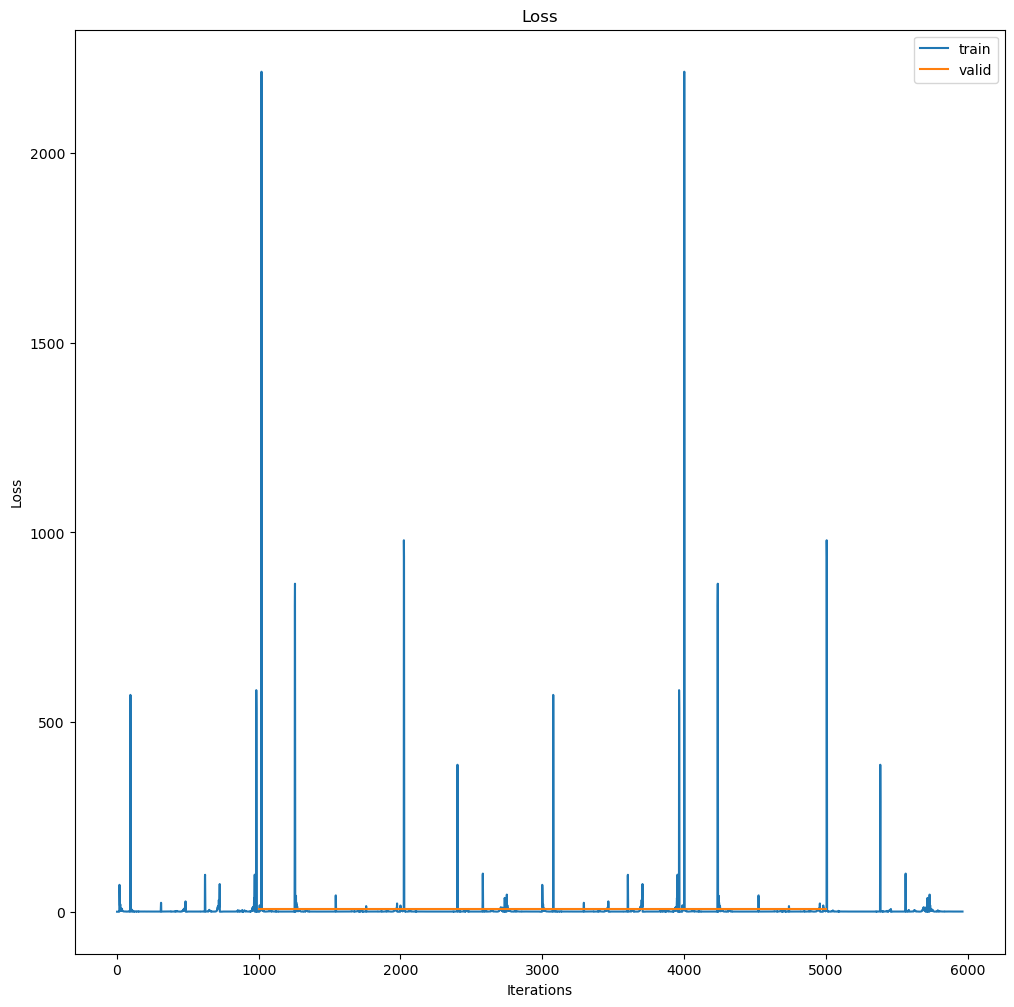

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

# visualize the loss curve
plt.figure(figsize=(12,12))
plt.plot(*zip(*train_loss), label="train")
plt.plot(*zip(*validate_loss), label="valid")
plt.title('Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing

In [38]:
from numpy import number
import torch
import torch_geometric as pyg

# read model from the file at args['model_path']

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = GNS()
state_dict = torch.load(args['model_path'], map_location=torch.device('cpu') if not torch.cuda.is_available() else torch.device('cuda'))
model.load_state_dict(state_dict)

test_dataset = OneStepDataset("dataset/WaterDropSample/", "data/test")
test_loader = pyg.data.DataLoader(test_dataset, batch_size=args['batch_size'], drop_last=True, shuffle=False)

idx = 0
for_video = torch.zeros((1000, 403, 2))

total_loss = 0
number_of_batches = 0

with torch.no_grad():
    model.eval()
    for batch, data in enumerate(test_loader):
        data = data.to(device)
        model = model.to(device)
        out = model(data)
        
        total_loss += F.mse_loss(out, data.y).item()
        number_of_batches += 1
        if batch % 100 == 0:
            print(f"Batch {batch} / {len(test_loader)}")
            
        if idx < 1000:
            try:
                print('out.shape:', out.shape)
                print('for_video[idx].shape:', for_video[idx].shape)
                for_video[idx] = out
                idx += 1
            except RuntimeError:
                break
        if idx == 1000:
            break
        
total_loss /= number_of_batches

Batch 0 / 745
out.shape: torch.Size([1556, 2])
for_video[idx].shape: torch.Size([403, 2])


In [30]:
print(f"Test loss: {total_loss}")
print(for_video.shape)
torch.save(for_video, "for_video.pt")

Test loss: 8750059.0
torch.Size([1000, 403, 2])
